In [ ]:
import os
import urllib.request
from datetime import datetime, timezone, timedelta
import pandas as pd 
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, GRU, TimeDistributed, RepeatVector, Lambda, Bidirectional
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model, clone_model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from keras.backend import clear_session
import time
import csv
from sklearn.externals import joblib

%matplotlib inline

In [ ]:
# 所有城市對照英文代碼
city = {
    '基隆市':'KLU',
    '臺北市':'TPE',
    '新北市':'TPH',
    '桃園市':'TYC',
    '新竹市':'HSC',
    '新竹縣':'HSH',
    '苗栗縣':'MAL',
    '臺中市':'TXG',
    '彰化縣':'CWH',
    '南投縣':'NTO',
    '雲林縣':'YLH',
    '嘉義市':'CYI',
    '嘉義縣':'CHY',
    '臺南市':'TNN',
    '高雄市':'KHH',
    '屏東縣':'IUH',
    '宜蘭縣':'ILN',
    '花蓮縣':'HWA',
    '臺東縣':'TTT'
}

# 資料與模型參數確認

In [ ]:
# 農作物
crop_dict = {
    1 : ['cabbage', '高麗菜', '(LA1 甘藍 初秋)'],
    2 : ['carrot', '胡蘿蔔', '(SB2 胡蘿蔔 清洗)'],
    3 : ['beeftomato', '牛番茄', '(FJ3 番茄 牛蕃茄)'],
    4 : ['cucumber', '胡瓜', '(FD1 花胡瓜)'],
    5 : ['loofah', '絲瓜', '(FF1 絲瓜)'],
    6 : ['cabbage2', '包心白菜', '(LC1 包心白 包白)'],
    7 : ['shallots', '青蔥', '(SE6 青蔥 粉蔥)'],
    8 : ['bittergourd', '苦瓜', '(FG1 苦瓜 白大米)'],
    9 : ['onion', '洋蔥', '(SD1 洋蔥 本產)'],
    10 : ['waterspinach', '空心菜', '(LF2 蕹菜 小葉)'],
    11 : ['spoon cabbage', '青江菜', '(LD1 青江白菜 小梗)'],
    12 : ['cauliflower', '花椰菜', '(FB11 花椰菜 青梗 留梗炳)'],

    
    13 : ['guava', '番石榴', '(P1 番石榴 珍珠芭)'],
    14 : ['pineapple', '鳳梨', '(B2 鳳梨 金鑽鳳梨)'],
    15 : ['papaya', '木瓜', '(I1 木瓜 網室紅肉)'],
    16 : ['watermelon', '西瓜', '(T1 西瓜 大西瓜)'],
    17 : ['banana', '香蕉', '(A1 香蕉)'],
    18 : ['pear', '梨子', '(O4 梨 新興梨)'],
    19 : ['grape', '葡萄', '(S1 葡萄 巨峰)'],
    20 : ['dragonfruit', '火龍果', '(812 火龍果 紅肉)'],
    21 : ['mango', '芒果', '(R1 芒果 愛文)'],
    22 : ['Cherry tomatoes ', '玉女番茄', '(74 小番茄 玉女)'],
    23 : ['lemon', '檸檬', '(F1 雜柑 檸檬)'],
    24 : ['apple', '蘋果', '(X69 蘋果 富士進口)']
}


In [ ]:
# 市場選定
market_dict = {
    1 : '台北一'
}

1. 時間設定
2. 資料區間
3. 模型相關選擇
4. 作圖
5. 儲存

In [ ]:
# 1. 
# 取得現在時間(TP) 並設定為 +8 時區
time_now = datetime.now(timezone(timedelta(hours=+8))).isoformat(timespec="seconds")[5:16].replace('-', '', 1).replace('T', '-')

# 2.
# 資料區間
# 選擇農產品，(13-24為水果)
crop_no = 18
dataset_path = '/content/drive/MyDrive/Ai團專_農時_共享資料夾/Dataset_資料集/模型訓練之資料集/fruit model vseion/model_dataset_'
print(dataset_path + crop_dict[crop_no][1] + '.csv')
# 選擇市場，目前只有1
market_no = 1
# 是否要刪除價格空值
price_na_del = True

# 是否要加入天氣資料
# add_weather_data = True
add_weather_data = False
# # 是否要加入颱風資料
add_typhoon_data = True
# add_typhoon_data = False
# 訂定訓練資料的期間、測試資料的期間
train_start_date = '2013-01-02'
train_end_date = '2020-05-31'
test_start_date = '2020-06-01'
test_end_date = '2021-06-18'
# 設定往前以及往後看的天數, 若many to many, past_day, future_day要設定一樣的值
pastDay = 3
futureDay = 1

# 3.
# 使用哪一個模型，目前有1-3
model_no = 3
repeat_train = True
# 模型每層參數 數量
# LSTM_unit_1 = 10
# LSTM_unit_2 = ''
LSTM_unit_1 = 256
LSTM_unit_2 = 16
# LSTM_unit_3 = 64
# 其它參數
batch_size = 30
# epochs = 1000
epochs = 400
validation_split = 0.1
patience = 40

# 4.
# 作圖
# 畫多少天的預測圖，要小於或等於上面的數字
plotDay = 1
# 畫到數一共幾天的預測圖
pic_days = 300

# 5.
# 是否要存入google drive
save_google = True
# save_route = '/content/drive/MyDrive/Ai團專_農時_共享資料夾/模型與成果/'
save_google_dir = '/content/drive/MyDrive/AI_project/result/'
dev_notes = ''

/content/drive/MyDrive/Ai團專_農時_共享資料夾/Dataset_資料集/模型訓練之資料集/fruit model vseion/model_dataset_梨子.csv


# 版本介紹與環境

價格預測版本s5，
此版本目的是 最終版
以市場為核心，選擇性與颱風氣候資料合併
重要資訊簡介:
1. 氣候資料為?日 vs 1天價格
2. 進行shift
3. 2000.01.02開始


In [ ]:
from google.colab import drive
if save_google: drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
def download_data():
    # 檔案下載url   
    weather_data_url = 'https://github.com/Yi-Wei-Lin/Tibame_AI_Project/raw/main/userdata/amoswu/dataset/reportdaily_mean_fillna.csv'
    typhoon_data_url = 'https://github.com/Yi-Wei-Lin/Tibame_AI_Project/raw/main/userdata/amoswu/dataset/TyphoonDatabase.csv'
    price_data_url = 'https://github.com/Yi-Wei-Lin/Tibame_AI_Project/raw/main/userdata/lynnbai/dataset/Banana.csv'
    # 將檔案下載至colab
    if not os.path.exists('weather.csv'): urllib.request.urlretrieve(weather_data_url, 'weather.csv') 
    if not os.path.exists('typhoon.csv'): urllib.request.urlretrieve(typhoon_data_url, 'typhoon.csv') 
    if not os.path.exists('banana.csv'): urllib.request.urlretrieve(price_data_url, 'banana.csv')
download_data()

In [ ]:
# for i in city_drop_list:
#     city_drop_columns.append([s for s in list(df_date.columns) if s.__contains__(i)])
# city_drop_columns = list(np.array(city_drop_columns).reshape(-1))

# dataset_path = '/content/drive/MyDrive/Ai團專_農時_共享資料夾/Dataset_資料集/模型訓練之資料集/fruit model vseion/model_dataset_木瓜.csv'
# dataset_path = '/content/drive/MyDrive/Ai團專_農時_共享資料夾/Dataset_資料集/模型訓練之資料集/fruit model vseion/model_dataset_'
# asdf = pd.read_csv(dataset_path + crop_dict[crop_no+1][1] + '.csv', encoding='utf-8')
# asdf
# crop_dict[13][1]


# 資料預處理 - 天氣

In [ ]:
# 要移除的欄位列表
# weather columb全部列表: 'date', 'city', 'StnPres', 'SeaPres', 'StnPresMax', 'StnPresMaxTime', 'StnPresMin', 'StnPresMinTime', 'Temperature', 'TMax', 'TMaxTime', 'TMin', 'TMinTime', 'TdDewPoint', 'RH', 'RHMin', 'RHMinTime', 'WS', 'WD', 'WSGust', 'WDGust', 'WGustTime', 'Precp', 'PrecpHour', 'PrecpMax10', 'PrecpMax10Time', 'PrecpMax60', 'PrecpMax60Time', 'SunShine', 'SunShineRate', 'GloblRad', 'VisbMean', 'EvapA', 'UVIMax', 'UVIMaxTime', 'CloudAmount'
weather_drop_columns = [
              'StnPres', 'SeaPres', 'StnPresMax', 'StnPresMaxTime', 
              'StnPresMin', 'StnPresMinTime', 'RHMin',  'WSGust', 
              'GloblRad', 'VisbMean', 'UVIMax', 'UVIMaxTime', 'CloudAmount'
]

In [ ]:
df = pd.read_csv('weather.csv', encoding='utf-8')
df = df.drop(weather_drop_columns, axis=1)
df.head(3)

,date,city,Temperature,TMax,TMaxTime,TMin,TMinTime,TdDewPoint,RH,RHMinTime,WS,WD,WDGust,WGustTime,Precp,PrecpHour,PrecpMax10,PrecpMax10Time,PrecpMax60,PrecpMax60Time,SunShine,SunShineRate,EvapA
0,2000-01-01,南投縣,9.0,14.3,2000-01-01 13:53:00,6.5,2000-01-01 19:22:00,1.1,60.0,2000-01-01 12:46:00,7.5,301.0,262.5,2000-01-01 17:41:00,0.0,0.0,0.0,NaN,0.0,NaN,9.8,91.5,2.8
1,2000-01-01,嘉義市,18.9,26.0,2000-01-01 13:37:00,13.4,2000-01-01 23:44:00,14.3,77.0,2000-01-01 15:53:00,2.0,20.0,30.0,2000-01-01 11:57:00,0.0,0.0,0.0,NaN,0.0,NaN,7.6,71.2,2.8
2,2000-01-01,嘉義縣,14.0,14.9,2000-01-01 11:45:00,3.7,2000-01-01 21:50:00,-3.6,44.0,2000-01-01 01:25:00,1.8,300.0,90.0,2000-01-01 06:18:00,0.0,0.0,0.0,NaN,0.0,NaN,9.2,96.5,2.1


In [ ]:
# 使用index做merge，將df表格依日期拉平
df_date = df['date'].drop_duplicates().to_frame().set_index('date')

for cityname, citycode in city.items():
    df_city = df.loc[df['city'] == cityname].add_suffix('_' + citycode).set_index('date' + '_' + citycode)
    df_date = pd.merge(df_date, df_city, how='left', left_index = True, right_index = True)
# 將城市名稱欄位移除
df_date = df_date[df_date.columns.drop(list(df_date.filter(regex='city')))]
df_weather = df_date
df_weather.head(3)

,Temperature_KLU,TMax_KLU,TMaxTime_KLU,TMin_KLU,TMinTime_KLU,TdDewPoint_KLU,RH_KLU,RHMinTime_KLU,WS_KLU,WD_KLU,WDGust_KLU,WGustTime_KLU,Precp_KLU,PrecpHour_KLU,PrecpMax10_KLU,PrecpMax10Time_KLU,PrecpMax60_KLU,PrecpMax60Time_KLU,SunShine_KLU,SunShineRate_KLU,EvapA_KLU,Temperature_TPE,TMax_TPE,TMaxTime_TPE,TMin_TPE,TMinTime_TPE,TdDewPoint_TPE,RH_TPE,RHMinTime_TPE,WS_TPE,WD_TPE,WDGust_TPE,WGustTime_TPE,Precp_TPE,PrecpHour_TPE,PrecpMax10_TPE,PrecpMax10Time_TPE,PrecpMax60_TPE,PrecpMax60Time_TPE,SunShine_TPE,...,TMaxTime_HWA,TMin_HWA,TMinTime_HWA,TdDewPoint_HWA,RH_HWA,RHMinTime_HWA,WS_HWA,WD_HWA,WDGust_HWA,WGustTime_HWA,Precp_HWA,PrecpHour_HWA,PrecpMax10_HWA,PrecpMax10Time_HWA,PrecpMax60_HWA,PrecpMax60Time_HWA,SunShine_HWA,SunShineRate_HWA,EvapA_HWA,Temperature_TTT,TMax_TTT,TMaxTime_TTT,TMin_TTT,TMinTime_TTT,TdDewPoint_TTT,RH_TTT,RHMinTime_TTT,WS_TTT,WD_TTT,WDGust_TTT,WGustTime_TTT,Precp_TTT,PrecpHour_TTT,PrecpMax10_TTT,PrecpMax10Time_TTT,PrecpMax60_TTT,PrecpMax60Time_TTT,SunShine_TTT,SunShineRate_TTT,EvapA_TTT
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-01,19.3,22.6,2000-01-01 12:28:30,16.9,2000-01-01 22:33:30,14.3,73.5,2000-01-01 19:56:00,3.8,280.0,180.0,2000-01-01 12:36:30,2.2,0.4,1.9,2000-01-01 03:00:00,2.2,2000-01-01 02:57:00,3.8,36.6,2.0,17.5,21.1,2000-01-01 14:05:44,14.3,2000-01-01 22:33:55,11.9,78.7,2000-01-01 19:43:00,1.2,230.9,197.3,2000-01-01 11:02:27,0.0,0.0,0.0,NaN,0.0,NaN,2.7,...,2000-01-01 12:10:40,13.5,2000-01-01 02:05:50,16.4,74.0,2000-01-01 10:56:00,0.8,221.7,162.7,2000-01-01 10:54:40,0.5,0.0,0.0,NaN,0.0,NaN,4.1,37.0,1.2,19.2,25.0,2000-01-01 11:34:18,17.7,2000-01-01 05:33:12,16.9,74.8,2000-01-01 08:28:30,1.8,119.2,75.2,2000-01-01 13:10:42,0.0,0.0,0.1,2000-01-01 01:45:00,0.1,2000-01-01 01:45:00,3.1,28.9,2.9
2000-01-02,18.6,21.7,2000-01-02 11:51:30,15.2,2000-01-02 15:26:00,11.4,64.5,2000-01-02 12:48:30,4.7,130.0,85.0,2000-01-02 20:07:00,0.0,0.0,0.0,NaN,0.0,NaN,8.5,79.8,2.6,16.8,22.6,2000-01-02 13:02:11,12.1,2000-01-02 08:10:22,9.0,68.7,2000-01-02 04:59:40,1.9,98.3,93.7,2000-01-02 20:01:05,0.0,0.0,0.0,NaN,0.0,NaN,7.6,...,2000-01-02 11:30:51,14.6,2000-01-02 11:12:43,13.7,62.0,2000-01-02 11:45:00,1.1,215.7,139.9,2000-01-02 11:21:43,0.3,0.0,0.0,NaN,0.0,NaN,2.6,23.0,1.5,17.9,22.1,2000-01-02 11:34:11,16.5,2000-01-02 11:06:44,14.1,64.0,2000-01-02 13:42:15,2.8,119.8,89.7,2000-01-02 14:44:27,0.0,0.0,0.0,NaN,0.0,NaN,4.2,38.9,3.6
2000-01-03,18.7,20.8,2000-01-03 13:12:00,16.3,2000-01-03 13:59:30,10.0,58.0,2000-01-03 12:57:00,3.9,60.0,85.0,2000-01-03 03:55:30,0.0,0.0,0.0,NaN,0.0,NaN,5.0,47.4,3.0,17.6,20.8,2000-01-03 12:44:49,15.3,2000-01-03 05:40:11,10.7,76.7,2000-01-03 13:20:40,2.3,79.2,89.0,2000-01-03 10:31:44,0.0,0.0,0.0,NaN,0.0,NaN,4.6,...,2000-01-03 11:25:43,12.9,2000-01-03 09:30:09,13.5,67.0,2000-01-03 13:55:00,0.8,210.9,172.4,2000-01-03 13:15:09,0.1,0.0,0.0,NaN,0.0,NaN,1.8,16.7,2.5,16.9,22.2,2000-01-03 12:24:00,16.2,2000-01-03 09:16:12,13.5,64.2,2000-01-03 11:48:45,2.2,101.1,66.7,2000-01-03 05:31:42,0.0,0.0,0.0,NaN,0.0,NaN,5.2,47.8,3.2


In [ ]:
# 城市drop名單
# city_drop = ['KLU', 'TPE', 'TPH', 'TYC', 'HSC', 'HSH', 'MAL', 'TXG', 'CWH', 
#         'NTO', 'YLH', 'CYI', 'CHY', 'TNN', 'KHH', 'IUH', 'ILN', 'HWA', 'TTT']
city_drop_list = ['KLU', 'TPH', 'TYC', 'HSC', 'HSH', 'MAL', 'TXG', 'CYI']
city_drop_columns = []
for i in city_drop_list:
    city_drop_columns.append([s for s in list(df_date.columns) if s.__contains__(i)])
city_drop_columns = list(np.array(city_drop_columns).reshape(-1))

# 資料預處理 - 颱風

In [ ]:
# 計算兩個日期間隔多少天
def daysBetweenDate(startdate: str, enddate: str) -> int:
    startdate = datetime.strptime(startdate, "%Y-%m-%d")
    enddate = datetime.strptime(enddate, "%Y-%m-%d")
    days = (enddate - startdate).days + 1
    return days

# 日期調整
def dateShift(startdate: str, shiftday: int) -> str:
    startdate = datetime.strptime(startdate, "%Y-%m-%d")
    targetdate = startdate + timedelta(days=shiftday)
    return datetime.strftime(targetdate, "%Y-%m-%d")

# 讀取颱風資料庫
df_typhoon = pd.read_csv('typhoon.csv', encoding='utf-8')

# 將Warning的日期文字轉為4個欄位'startdate','starttime','enddate','endtime'
df_typhoon[['startdate','starttime','enddate','endtime']] = df_typhoon['Warning'].str.split().tolist()
# 將最前面塞入date欄位
df_typhoon_new = pd.DataFrame(columns=df_typhoon.columns.insert(0, 'date'))

# 將所有颱風按日期列出
# 使用iterrows
start_time = time.time()
for index, row in df_typhoon.iterrows():
    days = daysBetweenDate(row['startdate'], row['enddate'])
    for day in range(0, days):
        date = dateShift(row['startdate'],day)
        datesr1 = pd.Series(date).append(df_typhoon.iloc[index]).rename({0: 'date'})
        df_typhoon_new = df_typhoon_new.append(datesr1, ignore_index=True)

# 將相同日期的去除並暫時只留WarnMark欄位
df_typhoon_wm = pd.DataFrame(df_typhoon_new, columns=['date'])
df_typhoon_wm['WarnMark'] = 1
df_typhoon_wm = df_typhoon_wm.drop_duplicates().reset_index().drop(columns=['index'])

df_typhoon = df_typhoon_wm.set_index('date')

print(df_typhoon.head(3))


            WarnMark
date                
2021-06-03         1
2021-06-04         1
2020-11-05         1


# 資料預處理 - 市場
1. 選定 台北一 市場
2. 補空值

In [ ]:
# 要移除的欄位列表
# market columns 全部列表: 'Date', 'Market', 'Product', 'Up_price', 'Mid_price', 'Low_price', 'Avg_price', 'Volume', 'Month', 'Week_day', 'Year', 'Rest_day'
market_drop_columns = [
              'Product',
              # 'Month', 
              # 'Week_day', 
              'Year', 
              'Rest_day'
]

In [ ]:
# 讀取農產品資料
# if not os.path.exists('banana.csv'): urllib.request.urlretrieve(price_data_url, 'banana.csv')

df = pd.read_csv(dataset_path + crop_dict[crop_no][1] + '.csv', encoding='utf-8')

# csv_name = crop_dict[crop_no][0] + '.csv'
# df = pd.read_csv(csv_name, encoding='utf-8')
# 移除不需要的欄位
df = df.drop(market_drop_columns, axis=1)
print(df.head(3))
print(df.tail(3))

         Date Market  Up_price  Mid_price  ...  Volume  Volume_diff  Month  Week_day
0  2000-01-02    三重區      51.5       41.7  ...  1802.0          NaN      1         7
1  2000-01-03    三重區      48.5       45.0  ...  2153.0        19.48      1         1
2  2000-01-04    三重區      63.6       48.2  ...  1301.0       -39.57      1         2

[3 rows x 11 columns]
             Date Market  Up_price  ...  Volume_diff  Month  Week_day
78298  2021-06-17    桃　農       NaN  ...          NaN      6         4
78299  2021-06-18    桃　農       NaN  ...          NaN      6         5
78300  2021-06-19    桃　農       NaN  ...          NaN      6         6

[3 rows x 11 columns]


In [ ]:
# 將休市價格填入前後日之平均價格(暫不使用)
def fillna_fb_mean(self):
    df_f = self.fillna(method='ffill')
    df_b = self.fillna(method='bfill')
    df_fb = (df_f+df_b)/2
    return df_fb

# price_na_del = False
# 去除價格空值者
if price_na_del:
    df = df
else:
    # 將休市價格填入前一日價格
    df = df.fillna(method="ffill")
    
# 只拿出指定市場的資料
df = df[df.Market == market_dict[market_no]]
# 去除空值
df = df.dropna()
df_crop = df.reset_index().drop(['index'], axis=1)
print(df_crop)

            Date Market  Up_price  ...  Volume_diff  Month  Week_day
0     2000-01-12    台北一      40.0  ...        92.00      1         3
1     2000-01-13    台北一      35.0  ...        -8.33      1         4
2     2000-01-19    台北一      35.0  ...       -72.73      1         3
3     2000-01-21    台北一      39.8  ...       766.67      1         5
4     2000-01-25    台北一      50.0  ...         3.08      1         2
...          ...    ...       ...  ...          ...    ...       ...
3798  2021-02-26    台北一      35.0  ...       -55.73      2         5
3799  2021-06-10    台北一      45.0  ...       343.37      6         4
3800  2021-06-11    台北一      60.0  ...        10.87      6         5
3801  2021-06-17    台北一      40.0  ...       -50.98      6         4
3802  2021-06-19    台北一      60.0  ...       -56.25      6         6

[3803 rows x 11 columns]


In [ ]:
# data_dum = pd.get_dummies(data)
# pd.DataFrame(data_dum)
from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder()
df_crop_month_ohe = onehotencoder.fit_transform(df_crop[["Month"]]).toarray()
month = pd.DataFrame(df_crop_month_ohe)
for i in month:
    new = int(i) + 1
    new = str(new)
    month = month.rename(columns={i:new})
month = month.add_prefix("Month_")
# df.loc[df['city'] == '基隆市'].add_suffix('_' + 'KLU')
# df.rename(columns={'舊欄位名稱': '新欄位名稱'}) .add_prefix("Month_")
onehotencoder = OneHotEncoder()
df_crop_week_ohe = onehotencoder.fit_transform(df_crop[["Week_day"]]).toarray()
week = pd.DataFrame(df_crop_week_ohe)
for i in week:
    new = int(i) + 1
    new = str(new)
    week = week.rename(columns={i:new})
week = week.add_prefix("Week_day_")

df_crop = df_crop.join(month, how="left")
df_crop = df_crop.join(week, how="left")
df_crop = df_crop.drop(['Month', 'Week_day'], axis=1).rename(columns={'Date': 'date'}).set_index('date')

In [ ]:
df_crop

,Market,Up_price,Mid_price,Low_price,Avg_price,Avg_price_diff,Volume,Volume_diff,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Week_day_1,Week_day_2,Week_day_3,Week_day_4,Week_day_5,Week_day_6,Week_day_7
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-12,台北一,40.0,40.0,40.0,40.0,-29.82,480.0,92.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2000-01-13,台北一,35.0,28.8,14.3,27.2,-32.00,440.0,-8.33,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2000-01-19,台北一,35.0,35.0,35.0,35.0,28.68,120.0,-72.73,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2000-01-21,台北一,39.8,31.9,29.0,32.9,-6.00,1040.0,766.67,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2000-01-25,台北一,50.0,47.0,40.1,46.2,40.43,1072.0,3.08,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-26,台北一,35.0,31.1,30.0,31.7,-36.60,166.0,-55.73,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2021-06-10,台北一,45.0,40.0,35.0,40.0,26.18,736.0,343.37,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2021-06-11,台北一,60.0,52.0,40.0,51.2,28.00,816.0,10.87,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# 資料預處理 - 氣象(天氣與颱風)
1. 決定 市場 是否將合併 天氣與颱風
2. 選出 與模型無關者排除
3. 確認無空值


df_all 資料合併之參數

In [ ]:
df_all = df_crop
# 是否要合併天氣資料
if add_weather_data:
    df_all = pd.merge(df_all, df_weather, how='inner', left_index = True, right_index = True)
# 是否要合併颱風資料
if add_typhoon_data:
    df_all = pd.merge(df_all, df_typhoon, how='left', left_index = True, right_index = True).fillna(0)

# 把平均價格移到最後1欄
col_Avg_price = df_all.pop('Avg_price')
df_all = pd.concat([df_all, col_Avg_price], 1)
print(df_all.head(3))
print(df_all.tail(3))

           Market  Up_price  Mid_price  ...  Week_day_7  WarnMark  Avg_price
date                                    ...                                 
2000-01-12    台北一      40.0       40.0  ...         0.0       0.0       40.0
2000-01-13    台北一      35.0       28.8  ...         0.0       0.0       27.2
2000-01-19    台北一      35.0       35.0  ...         0.0       0.0       35.0

[3 rows x 28 columns]
           Market  Up_price  Mid_price  ...  Week_day_7  WarnMark  Avg_price
date                                    ...                                 
2021-06-11    台北一      60.0       52.0  ...         0.0       0.0       51.2
2021-06-17    台北一      40.0       33.3  ...         0.0       0.0       34.0
2021-06-19    台北一      60.0       57.9  ...         0.0       0.0       56.2

[3 rows x 28 columns]


Dataset 空值數量確認

In [ ]:
# 確認無空值
def dataset_na_check():
    market_tp1_na_count = df_crop.isna().sum()
    weather_na_count = df_weather.isna().sum()

    total_na_count = list() # 氣象空值查找
    for i in range(len(weather_na_count.index)):
        if weather_na_count.values[i] != 0 :
            total_na_count.append([weather_na_count.index[i], weather_na_count.values[i]])

    print(market_tp1_na_count)
    print('--------------------')
    print(weather_na_count)
    print('--------------------')
    print(len(total_na_count))
dataset_na_check()

Market            0
Up_price          0
Mid_price         0
Low_price         0
Avg_price         0
Avg_price_diff    0
Volume            0
Volume_diff       0
Month_1           0
Month_2           0
Month_3           0
Month_4           0
Month_5           0
Month_6           0
Month_7           0
Month_8           0
Month_9           0
Month_10          0
Month_11          0
Month_12          0
Week_day_1        0
Week_day_2        0
Week_day_3        0
Week_day_4        0
Week_day_5        0
Week_day_6        0
Week_day_7        0
dtype: int64
--------------------
Temperature_KLU          0
TMax_KLU                 0
TMaxTime_KLU             0
TMin_KLU                 0
TMinTime_KLU             0
                      ... 
PrecpMax60_TTT           0
PrecpMax60Time_TTT    1842
SunShine_TTT             0
SunShineRate_TTT         0
EvapA_TTT                0
Length: 399, dtype: int64
--------------------
38


資料Batch化函式 \
1. buildX
2. buildY

# 模型輸入值建立

In [ ]:
# 將資料整理為x
def buildX(train, pastDay=30, futureDay=5):
    x = []
    for i in range(train.shape[0] - futureDay - pastDay):
        x.append(train[i : i+pastDay])
    return np.array(x)

# 將資料整理為y
def buildY(test, pastDay=30, futureDay=5):
    y = []
    for i in range(test.shape[0] - futureDay - pastDay):
        y.append(test[i+pastDay+futureDay : i+pastDay+futureDay+1, -1])
    return np.array(y)

依照訓練、測試的期間來切分資料 \
df_train 與 df_test

In [ ]:
# 將資料複製一份來作業, 將欄位index改為date
df = df_all.copy()
df = df.reset_index().rename(columns={'index': 'date'})

# 依訓練資料的期間、測試資料的期間來切分資料
df_train = df.iloc[df[(train_start_date <= df.date) & (df.date <= train_end_date)].index].set_index('date')
df_test = df.iloc[df[(test_start_date <= df.date) & (df.date <= test_end_date)].index].set_index('date')

# 將非數字的欄位移除
df_train = df_train.select_dtypes(exclude=['object'])
df_test = df_test.select_dtypes(exclude=['object'])

print(df_train.shape)
print(df_test.shape)
print(df_train.dtypes)

# print(df_train.isna().sum().sum())
# print(df_test.isna().sum().sum())

(1048, 27)
(140, 27)
Up_price          float64
Mid_price         float64
Low_price         float64
Avg_price_diff    float64
Volume            float64
Volume_diff       float64
Month_1           float64
Month_2           float64
Month_3           float64
Month_4           float64
Month_5           float64
Month_6           float64
Month_7           float64
Month_8           float64
Month_9           float64
Month_10          float64
Month_11          float64
Month_12          float64
Week_day_1        float64
Week_day_2        float64
Week_day_3        float64
Week_day_4        float64
Week_day_5        float64
Week_day_6        float64
Week_day_7        float64
WarnMark          float64
Avg_price         float64
dtype: object


x_train, x_test 為  MinMaxScaler後之資料 \\
y_train, y_test 為  MinMaxScaler後之價格資料


In [ ]:
# train 正則化
df_train_scaled = df_train.values
xx_scale = MinMaxScaler()
x_train = buildX(xx_scale.fit_transform(df_train_scaled), pastDay, futureDay)
print('x_train.shape', x_train.shape)

yy_scale = MinMaxScaler()
y_train_fitted_data = yy_scale.fit_transform(df_train_scaled[:, -1].reshape(-1, 1))
y_train = buildY(y_train_fitted_data, pastDay, futureDay)
print('y_train.shape: ', y_train.shape)

# test 正則化
df_test_scaled = df_test.values
x_test = buildX(xx_scale.fit_transform(df_test_scaled), pastDay, futureDay)
print('x_test.shape: ', x_test.shape)

y_test = buildY(yy_scale.fit_transform(df_test_scaled[:, -1].reshape(-1, 1)), pastDay, futureDay)
print('y_test.shape: ', y_test.shape)

x_train.shape (1044, 3, 27)
y_train.shape:  (1044, 1)
x_test.shape:  (136, 3, 27)
y_test.shape:  (136, 1)


# 模型選擇

In [ ]:
# 模型1 (純雙層LSTM)
def buildManyToOneModel01(shape):
    model = Sequential()
    # model.add(GRU(units=256,
    #     return_sequences=False,
    #     input_shape=(shape[1], shape[2])))
    
    model.add(LSTM(units=LSTM_unit_1,
        return_sequences=True,
        input_shape=(shape[1], shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=LSTM_unit_2, return_sequences=False,))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='mse', optimizer='adam')
    model.summary()
    return model

In [ ]:
# 模型2 (LSTM 搭配Biderectional)
def buildManyToOneModel02(shape):
    model = Sequential()
    # model.add(GRU(units=256,
    #     return_sequences=False,
    #     input_shape=(shape[1], shape[2])))
    
    # model.add(Bidirectional(LSTM(units=LSTM_unit_1,
    #     return_sequences=True,
    #     input_shape=(shape[1], shape[2])
    #     )))
    model.add(LSTM(units=LSTM_unit_1,
        return_sequences=True,
        input_shape=(shape[1], shape[2])
        ))
    model.add(Dropout(0.2))
    # model.add(LSTM(units=LSTM_unit_2, 
    #             return_sequences=False, 
    #             input_shape=(shape[1], shape[2]),
    #             go_backwards=True
    #             ))
    model.add(Bidirectional(LSTM(units=LSTM_unit_2, 
                return_sequences=False, 
                input_shape=(shape[1], shape[2]),
                go_backwards=True
                )))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='mse', optimizer='adam')
    model.build((None, shape[1], shape[2]))
    model.summary()
    return model

In [ ]:
# 模型3
def buildManyToOneModel03(shape):
    model = Sequential()
    model.add(LSTM(LSTM_unit_1, return_sequences=False, input_shape=(shape[1], shape[2])))
    # model.add(Dropout(0.2))
    # model.add(LSTM(LSTM_unit_2, return_sequences=True))
    # model.add(Dropout(0.2))
    # model.add(LSTM(LSTM_unit_3, return_sequences=True))
    # model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    # model.add(TimeDistributed(Dense(1)))
    # layers = [
    #     LSTM(units=LSTM_unit_1, return_sequences=False, input_shape=(shape[1], shape[2])),
    #     # Dense(units=128, activation="relu"),
    #     # Dense(units=10, activation="relu"),
    #     Dense(units=1, activation='sigmoid')]
    # model = Sequential(layers)
    model.compile(loss="mse", optimizer="adam", metrics=["mse"])
    model.summary()
    return model



# 模型訓練

In [ ]:
# 模型字典: function name, 說明, 是否shift day, 是否只輸出1天
model_dict = {
    1 : [buildManyToOneModel01, 'LSTM many to one', True, True],
    2 : [buildManyToOneModel02, 'LSTM & Biderectional many to one', True, True],
    3 : [buildManyToOneModel03, 'One LSTM to one', True, True],
    # 4 : [buildManyToOneModel4, 'LSTM many to one', True, True],
    5 : ['', ''],
}

In [ ]:
# 模型訓練
if model_no == 1:
    model = buildManyToOneModel01(x_train.shape)
    print('model1')
    model_name = 'buildManyToOneModel01'
elif model_no == 2:
    model = buildManyToOneModel02(x_train.shape)
    print('model2')
    model_name = 'buildManyToOneModel02'
elif model_no == 3:
    model = buildManyToOneModel03(x_train.shape)
    model_name = 'buildManyToOneModel03'
    if repeat_train:
        model_repeat1 = clone_model(model)
        model_repeat2 = clone_model(model)
        model_repeat3 = clone_model(model)
        model_repeat4 = clone_model(model)
        model_repeat5 = clone_model(model)
    print('model3')
else:
    print('選錯model了')

callback = EarlyStopping(monitor="val_loss", patience=patience, verbose=1, mode="auto")


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 256)               290816    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 291,073
Trainable params: 291,073
Non-trainable params: 0
_________________________________________________________________
model3


# 模型相關函式建立

In [ ]:
def model_load(h5_name):
    model = load_model(f'{save_google_dir}h5/{h5_name}')
    print("MODEL-LOADED")
    return model
# def model_fit():
#     model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split, callbacks=[callback])
#     return model


In [ ]:
# scaler 存檔
def scaler_save():
    joblib.dump(xx_scale, save_google_dir + 'scaler/' + f'{crop_dict[crop_no][0]}_{time_now}_P{pastDay}F{futureDay}_RMSE={int(round(RMSE, 0))}' + 'X_scaler.model')
    joblib.dump(yy_scale, save_google_dir + 'scaler/' + f'{crop_dict[crop_no][0]}_{time_now}_P{pastDay}F{futureDay}_RMSE={int(round(RMSE, 0))}' + 'Y_scaler.model')
# scaler模型獲取
def scaler_load(scaler_time):
    xx_scale = joblib.load(save_google_dir + 'scaler/' + f'{crop_dict[crop_no][0]}_{scaler_time}_P{pastDay}F{futureDay}_RMSE={int(round(RMSE, 0))}' + 'X_scaler.model')
    yy_scale = joblib.load(save_google_dir + 'scaler/' + f'{crop_dict[crop_no][0]}_{scaler_time}_P{pastDay}F{futureDay}_RMSE={int(round(RMSE, 0))}' + 'Y_scaler.model')
    return xx_scale, yy_scale


In [ ]:
def model_save(model):
    # 儲存模型
    # if RMSE_dict[RMSE_min][2] == 6:
    # if RMSE_dict[RMSE_esb][2] == 6:
    #     print('123')
    #     for model in RMSE_dict[RMSE_min][1]:
    #         model.save((time_now) + f'_{}' + '.h5')
    #         if save_google: model.save(save_google_dir + 'h5/' + (time_now) + '.h5')   
    # else:
        # model.save((time_now) + '.h5')
        # if save_google: model.save(save_google_dir + 'h5/' + (time_now) + '.h5')
    model.save((time_now) + '.h5')
    if save_google: model.save(save_google_dir + 'h5/' + f'{crop_dict[crop_no][0]}_{time_now}_P{pastDay}F{futureDay}_RMSE={int(round(RMSE, 0))}.h5')
    print('MODEL-SAVED')


fit()用於訓練具有給定輸入的模型。

predict()用於實際預測。它爲輸入樣本生成輸出預測。

evaluate()用於評估已經過訓練的模型。返回模型的損失值&指標值。

In [ ]:
def model_cal(model):
    score = model.evaluate(x_test, y_test)
    print('Score: {}'.format(score))
    y_pre = model.predict(x_test)
    print('y_pre.shape:', y_pre.shape, 'y_test.shape:', y_test.shape)
    return y_pre

# 模型產出、處理、作圖與儲存

預測結果與實際結果的 數值迴轉 \
y_pre  --> pre_price \
y_test --> test_price

In [ ]:
def price_inverse(y_pre):
    pre_price = yy_scale.inverse_transform(y_pre)
    test_price = yy_scale.inverse_transform(y_test)
    diff_price = pre_price - test_price
    # print('pre_price.shape: ', pre_price.shape)
    # print('test_price.shape: ', test_price.shape)
    # print('diff_price.shape: ', diff_price.shape)
    # print('pre_price[:3]: ', pre_price[:3])
    return pre_price, test_price, diff_price

In [ ]:
# 畫圖
def DrawingPlot(pre_price, test_price, pic_days):
    plt.figure(figsize=(15,5))
    plt.plot(test_price[-pic_days:], label='Real Price')
    plt.plot(pre_price[-pic_days:], label='Predict Price')
    # plt.bar(np.arange(pic_days), diff_price[-pic_days:].reshape(-1), color='r', label='Diff', align='center')
    # plt.plot(diff_price[-pic_days:], color='r', label='Diff')
    plt.xlabel('day')   
    plt.ylabel('price')
    plt.title(crop_dict[crop_no][0] + ' predict D' + str(futureDay) + ' price')
    # plt.title(f'model-no.{model_no}_{model_version}_{pastDay}days for D{futureDay}')
    plt.legend()
    if save_google: plt.savefig(save_google_dir + 'img/' + f'{crop_dict[crop_no][0]}_{time_now}_P{pastDay}F{futureDay}_RMSE={int(round(RMSE, 0))}' + '.png')
    # if save_google: plt.savefig(save_google_dir + 'img/' + time_now + '_D' + str(futureDay) + '.png')
    # plt.savefig(f'{save_google_dir}img/{model_version}_{time_now}.png')  
    print('pic_saved')
    plt.show()
# f'{crop_dict[crop_no][0]}_{time_now}_P{pastDay}F{futureDay}_RMSE={int(round(RMSE, 0))}.h5'
# f'{crop_dict[crop_no][0]}_{time_now}_P{pastDay}F{futureDay}_RMSE={int(round(RMSE, 0))}'

In [ ]:
# 計分
def score_cal(pre_price):
    MSE = mean_squared_error(test_price.reshape(-1, 1), pre_price.reshape(-1, 1))
    RMSE = np.sqrt(MSE)
    MAE = mean_absolute_error(test_price.reshape(-1, 1), pre_price.reshape(-1, 1))
    R2 = r2_score(test_price.reshape(-1, 1), pre_price.reshape(-1, 1))
    print(f"MSE value : {MSE}", f"\nRMSE value : {RMSE}", f"\nMAE value : {MAE}", f"\nR2 score value : {R2}")
    return MSE, RMSE, MAE, R2

儲存每一次試驗資訊

In [ ]:
# 記錄結果
result_column_lists = ['time_now', 'crop_name', 'market_name', 'add_weather_data', 'add_typhoon_data', 'train_start_date', 
              'x_train.shape', 'x_test.shape', 
              'model_no', 'model_name', 'pastday', 'futureDay', 'batch_size', 'epochs', 'validation_split', 'patience', 
              'predDay', 'MSE', 'RMSE', 'MAE', 'R2', 'weather_drop_columns', 'city_drop_list', 'market_drop_columns', 'dev_notes', 'LSTM_unit_1', 'LSTM_unit_2', 'repeat_train']

# def saveResult(path, preDay, real_value, pred_value):
#   with open(path, 'a', newline='', encoding='utf-8') as f:
#     result_writer = csv.writer(f)
#     if f.tell()==0: result_writer.writerow(result_column_lists)
#     for i in range(preDay):
#       # i + 1 = 未來1日的價格
#       Dday = i + 1
#       # real_price = real_value[Dday:]
#       # pred_price = pred_value[:-Dday,i]

#       # MSE = mean_squared_error(real_price, pred_price)
#       # RMSE = np.sqrt(MSE)
#       # R2 = r2_score(real_price, pred_price)
      
#       result_lists = [datetime_now, crop_dict[crop_no][1], market_dict[market_no], add_weather_data, add_typhoon_data, train_start_date, model_no, model_dict[model_no][1], pastDay, futureDay, batch_size, epochs, validation_split, Dday, MSE, RMSE, MAE, R2]
#       result_writer.writerow(result_lists)

def saveResultOne(path, preDay):
    with open(path, 'a', newline='', encoding='utf-8') as f:
        result_writer = csv.writer(f)
        if f.tell()==0: result_writer.writerow(result_column_lists)
        # real_price = real_value
        # pred_price = pred_value
        # MSE = mean_squared_error(real_price, pred_price)
        # RMSE = np.sqrt(MSE)
        # R2 = r2_score(real_price, pred_price)
    
        result_lists = [time_now, crop_dict[crop_no][1], market_dict[market_no], add_weather_data, add_typhoon_data, train_start_date, 
                    x_train.shape, x_test.shape, 
                    model_no, model_dict[model_no][1], pastDay, futureDay, batch_size, epochs, validation_split, patience,
                    preDay, MSE, RMSE, MAE, R2, weather_drop_columns, city_drop_list, market_drop_columns, dev_notes, LSTM_unit_1, LSTM_unit_2, f'repeat={repeat_train}']
        result_writer.writerow(result_lists)      


# 執行

In [ ]:
if model_no == 3 and repeat_train == True:
    model_repeat1.compile(loss="mse", optimizer="adam", metrics=["mse"])
    train_history1 = model_repeat1.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split, callbacks=[callback])
    model_repeat2.compile(loss="mse", optimizer="adam", metrics=["mse"])
    train_history2 = model_repeat2.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split, callbacks=[callback])
    model_repeat3.compile(loss="mse", optimizer="adam", metrics=["mse"])
    train_history3 = model_repeat3.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split, callbacks=[callback])
    model_repeat4.compile(loss="mse", optimizer="adam", metrics=["mse"])
    train_history4 = model_repeat4.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split, callbacks=[callback])
    model_repeat5.compile(loss="mse", optimizer="adam", metrics=["mse"])
    train_history5 = model_repeat5.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split, callbacks=[callback])
else:
    train_history1 =  model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split, callbacks=[callback])


Epoch 1/400
32/32 [==============================] - 3s 24ms/step - loss: 0.0166 - mse: 0.0166 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 2/400
32/32 [==============================] - 0s 6ms/step - loss: 0.0098 - mse: 0.0098 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 3/400
32/32 [==============================] - 0s 5ms/step - loss: 0.0095 - mse: 0.0095 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 4/400
32/32 [==============================] - 0s 6ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 5/400
32/32 [==============================] - 0s 6ms/step - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 6/400
32/32 [==============================] - 0s 5ms/step - loss: 0.0074 - mse: 0.0074 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 7/400
32/32 [==============================] - 0s 6ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 8/400
32/32 [==============================] - 0s 6ms/step - loss: 0.0065 - 

In [ ]:
# # 模型3-2
# model_repeat2 = Sequential()
# model_repeat2.add(LSTM(LSTM_unit_1, return_sequences=False, input_shape=(x_train.shape[1], x_train.shape[2])))
# model_repeat2.add(Dense(1, activation='sigmoid'))
# model_repeat2.compile(loss="mse", optimizer="adam")
# model_repeat2.summary()
# train_history2 =  model_repeat2.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split, callbacks=[callback])


In [ ]:
# # 模型3-3
# model_repeat3 = Sequential()
# model_repeat3.add(LSTM(LSTM_unit_1, return_sequences=False, input_shape=(x_train.shape[1], x_train.shape[2])))
# model_repeat3.add(Dense(1, activation='sigmoid'))
# model_repeat3.compile(loss="mse", optimizer="adam")
# model_repeat3.summary()
# train_history3 =  model_repeat3.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split, callbacks=[callback])


In [ ]:
# # 模型3-4
# model_repeat4 = Sequential()
# model_repeat4.add(LSTM(LSTM_unit_1, return_sequences=False, input_shape=(x_train.shape[1], x_train.shape[2])))
# model_repeat4.add(Dense(1, activation='sigmoid'))
# model_repeat4.compile(loss="mse", optimizer="adam")
# model_repeat4.summary()
# train_history4 =  model_repeat4.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split, callbacks=[callback])


In [ ]:
# # 模型3-5
# model_repeat5 = Sequential()
# model_repeat5.add(LSTM(LSTM_unit_1, return_sequences=False, input_shape=(x_train.shape[1], x_train.shape[2])))
# model_repeat5.add(Dense(1, activation='sigmoid'))
# model_repeat5.compile(loss="mse", optimizer="adam")
# model_repeat5.summary()
# train_history5 =  model_repeat5.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split, callbacks=[callback])


In [ ]:
# 執行模型，預測價格
if model_no == 3 and repeat_train == True:
    y_pre1 = model_cal(model_repeat1)
    y_pre2 = model_cal(model_repeat2)
    y_pre3 = model_cal(model_repeat3)
    y_pre4 = model_cal(model_repeat4)
    y_pre5 = model_cal(model_repeat5)
else:
    y_pre = model_cal(model) 
  
# MSE, RMSE, MAE, R2 = score_cal()

5/5 [==============================] - 0s 4ms/step - loss: 0.0285 - mse: 0.0285
Score: [0.028506748378276825, 0.028506748378276825]
y_pre.shape: (136, 1) y_test.shape: (136, 1)
5/5 [==============================] - 0s 4ms/step - loss: 0.0304 - mse: 0.0304
Score: [0.03040066547691822, 0.03040066547691822]
y_pre.shape: (136, 1) y_test.shape: (136, 1)
5/5 [==============================] - 0s 4ms/step - loss: 0.0291 - mse: 0.0291
Score: [0.02906704694032669, 0.02906704694032669]
y_pre.shape: (136, 1) y_test.shape: (136, 1)
5/5 [==============================] - 0s 4ms/step - loss: 0.0242 - mse: 0.0242
Score: [0.024163061752915382, 0.024163061752915382]
y_pre.shape: (136, 1) y_test.shape: (136, 1)
5/5 [==============================] - 0s 4ms/step - loss: 0.0271 - mse: 0.0271
Score: [0.0270833782851696, 0.0270833782851696]
y_pre.shape: (136, 1) y_test.shape: (136, 1)


In [ ]:
# 計算分數
if model_no == 3 and repeat_train == True:
    # 建立各模型的轉換價格，並計算分數
    pre_price1, test_price, diff_price1 = price_inverse(y_pre1)
    pre_price2, test_price, diff_price2 = price_inverse(y_pre2)
    pre_price3, test_price, diff_price3 = price_inverse(y_pre3)
    pre_price4, test_price, diff_price4 = price_inverse(y_pre4)
    pre_price5, test_price, diff_price5 = price_inverse(y_pre5)
    print('*'*10 + '1' +'*'*10)
    MSE_1, RMSE_1, MAE_1, R2_1 = score_cal(pre_price1)
    print('*'*10 + '2' +'*'*10)
    MSE_2, RMSE_2, MAE_2, R2_2 = score_cal(pre_price2)
    print('*'*10 + '3' +'*'*10)
    MSE_3, RMSE_3, MAE_3, R2_3 = score_cal(pre_price3)
    print('*'*10 + '4' +'*'*10)
    MSE_4, RMSE_4, MAE_4, R2_4 = score_cal(pre_price4)
    print('*'*10 + '5' +'*'*10)
    MSE_5, RMSE_5, MAE_5, R2_5 = score_cal(pre_price5)
    pre_price_list = [pre_price1, pre_price2, pre_price3, pre_price4, pre_price5 ]
    # # ensemble轉換價格，並計算分數
    # ensemble_pre_price = (pre_price1 + pre_price2 + pre_price3 + pre_price4 + pre_price5)/5
    # MSE_esb, RMSE_esb, MAE_esb, R2_esb = score_cal(ensemble_pre_price)

    # 建立RMSE字典， 並由之找出最小值作為最終模型
    # RMSE_min = min([RMSE_1, RMSE_2, RMSE_3, RMSE_4, RMSE_5, RMSE_esb])
    RMSE_min = min([RMSE_1, RMSE_2, RMSE_3, RMSE_4, RMSE_5])
    RMSE_dict = {
        RMSE_1:[score_cal(pre_price1), model_repeat1, 1], 
        RMSE_2:[score_cal(pre_price2), model_repeat2, 2], 
        RMSE_3:[score_cal(pre_price3), model_repeat3, 3], 
        RMSE_4:[score_cal(pre_price4), model_repeat4, 4],
        RMSE_5:[score_cal(pre_price5), model_repeat5, 5],
        # RMSE_esb:[score_cal(ensemble_pre_price), [model_repeat1, 
        #                        model_repeat2,
        #                        model_repeat3,
        #                        model_repeat4,
        #                        model_repeat5], 6], 
    }

    # 確認1-5中最終版之MSE, RMSE, MAE, R2, pre_price
    MSE, RMSE, MAE, R2 = RMSE_dict[RMSE_min][0]
    pre_price = pre_price_list[RMSE_dict[RMSE_min][2]-1]
else:
    # 轉換價格，並計算分數
    pre_price, test_price, diff_price = price_inverse(y_pre)
    MSE, RMSE, MAE, R2 = score_cal(pre_price)

print(MSE, RMSE, MAE, R2)

**********1**********
MSE value : 102.62429027513116 
RMSE value : 10.130364765156838 
MAE value : 6.9617588463951545 
R2 score value : 0.23089089571071997
**********2**********
MSE value : 109.442402755344 
RMSE value : 10.461472303425747 
MAE value : 7.308091696570901 
R2 score value : 0.17979312569407502
**********3**********
MSE value : 104.64137221587475 
RMSE value : 10.229436554174171 
MAE value : 6.837689789603736 
R2 score value : 0.21577404490898222
**********4**********
MSE value : 86.98701730508054 
RMSE value : 9.326683081625564 
MAE value : 6.080154856513527 
R2 score value : 0.34808312159875654
**********5**********
MSE value : 97.50017369237734 
RMSE value : 9.874217624317247 
MAE value : 6.7014795836280365 
R2 score value : 0.2692931560788061
MSE value : 102.62429027513116 
RMSE value : 10.130364765156838 
MAE value : 6.9617588463951545 
R2 score value : 0.23089089571071997
MSE value : 109.442402755344 
RMSE value : 10.461472303425747 
MAE value : 7.308091696570901 
R2

# 新增區段

In [ ]:
# h5_list = ['banana_prediction_model_v2_s2_0728-13:15.h5']
# for h5_name in h5_list: 
#     model_load(h5_name) 

# y_pre = model_cal()
# pre_price, test_price, diff_price = price_inverse()
# MSE, RMSE, MAE, R2 = score_cal()
# clear_session()

In [ ]:
# 統計數值建立
asd = list(df['Avg_price'].values)
print(np.mean(asd))
print(np.median(asd))
print(np.percentile(asd, [25, 50, 75]))
print(MAE/np.mean(asd))
MAE/np.percentile(asd, [25, 50, 75])
np.std(asd, ddof=1)

40.764107283723376
39.9
[34.6 39.9 46.4]
0.14915461815942332


10.264996094989488

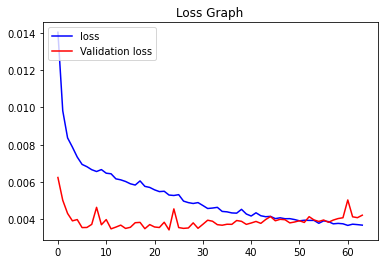

In [ ]:
# 印出第一個模型
plt.title('Loss Graph')
plt.plot(train_history1.history['loss'], 'blue', label='loss')
plt.plot(train_history1.history['val_loss'], 'red', label='Validation loss')
plt.legend(loc="upper left")

In [ ]:
# save the result
is_output_one = model_dict[model_no][3]
if is_output_one:
    saveResultOne('result.csv', futureDay)
    if save_google: saveResultOne(save_google_dir + 'result.csv', futureDay)
# else: 
#     saveResult('result.csv', futureDay, rp, pp)
#     if save_google: saveResult(save_google_dir + 'result.csv', futureDay, rp, pp)

if model_no ==3:
    model_save(RMSE_dict[RMSE_min][1])
else:
    model_save(model)
scaler_save()

MODEL-SAVED


pic_saved


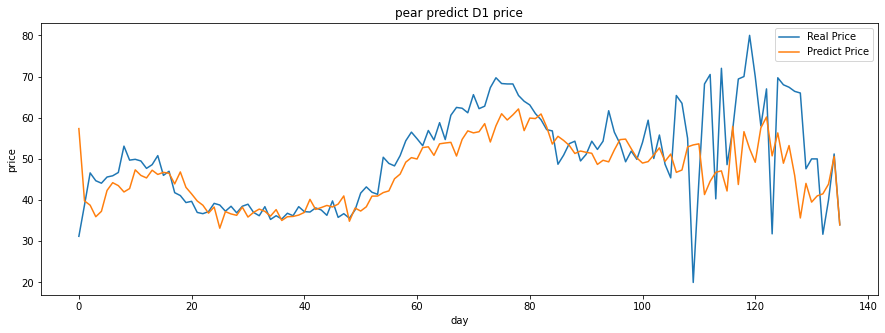

In [ ]:
DrawingPlot(pre_price, test_price, pic_days)


https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/ \\
The input to every LSTM layer must be three-dimensional.

The three dimensions of this input are:

1. Samples. One sequence is one sample. A batch is comprised of one or more samples.
2. Time Steps. One time step is one point of observation in the sample.
3. Features. One feature is one observation at a time step.